In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import wandb
from IPython.display import Image

In [3]:
torch.__version__

'1.7.1'

In [4]:
from cora_data import CoraData
from models import NodeClassifier
from train import run_one_epoch

In [6]:
wandb.login()

True

In [7]:
data_root = os.path.join(os.path.expanduser('~/ml_datasets/'), 'cora')
val_frac = 0.15
test_frac = 0.15
data = CoraData(data_root, val_frac, test_frac)

In [8]:
embeddings = torch.nn.Embedding(
    num_embeddings=data.features.shape[0],
    embedding_dim=data.features.shape[1]
)
embeddings.weight = torch.nn.Parameter(torch.from_numpy(data.features).float())
embeddings.weight.requires_grad = False

In [9]:
# Specify config
num_classes = len(data.class2id)
input_dim = data.features.shape[1]

# Training parameters
epochs = 15
batch_size = 256
learning_rate = 0.03

# GraphSAGE parameters
num_sampled_neighbors = 10
K = 2
hidden_dims = [512, 128]
agg_method = 'mean'


config_dict = {
    'num_classes': num_classes,
    'input_dim': input_dim,
    'epochs': epochs,
    'batch_size': 256,
    'learning_rate': learning_rate,
    'num_sampled_neighbors': num_sampled_neighbors,
    'K': K,
    'hidden_dims': hidden_dims,
    'agg_method': agg_method    
}

In [10]:
def make_model(config_dict):
    
    model = NodeClassifier(
        num_classes=config_dict['num_classes'],
        input_dim=config_dict['input_dim'],
        hidden_dims=config_dict['hidden_dims'],
        K=config_dict['K'],
        agg_method=config_dict['agg_method']
    )
    
    optimizer = optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=config_dict['learning_rate']
    )
    
    loss_func = torch.nn.CrossEntropyLoss()
    
    return model, optimizer, loss_func

In [11]:
def train_model(data, model, optimizer, loss_func, config_dict):
    
    wandb.watch(model, loss_func, log="all", log_freq=1)
    
    for epoch_idx in range(config_dict['epochs']):
        # training
        model.train()
        train_loss, train_acc = run_one_epoch(
            model, 
            optimizer,
            loss_func,
            data.train_nodes,
            data.labels,
            data.adjList,
            embeddings,
            config_dict['batch_size'],
            config_dict['num_sampled_neighbors'],
            config_dict['K'],
            True
        )
        
        # validation
        model.eval()
        val_loss, val_acc = run_one_epoch(
            model, 
            None,
            loss_func,
            data.val_nodes,
            data.labels,
            data.adjList,
            embeddings,
            config_dict['batch_size'],
            config_dict['num_sampled_neighbors'],
            config_dict['K'],
            False
        )
        
        # log metrics
        wandb.log(
            {'epoch': epoch_idx, 
             'train_loss': train_loss, 'val_loss': val_loss,
             'train_acc': train_acc, 'val_acc': val_acc
            }, 
            step=epoch_idx
        )
        

In [12]:
def model_pipeline(data, config_dict, path_to_model='./model.pt'):
    
    with wandb.init(project='GraphSAGE-PyTorch-cora', config=config_dict):
        
        model, optimizer, loss_func = make_model(config_dict)

        train_model(data, model, optimizer, loss_func, config_dict)
        
        # save the model
        torch.save(model.state_dict(), path_to_model)
        # reload the model        
        loaded_model, _, _ = make_model(config_dict)
        loaded_model.load_state_dict(torch.load('model.pt'))        
        
        # final evaluation on test set
        loaded_model.eval()
        test_loss, test_acc = run_one_epoch(
            loaded_model, 
            None,
            loss_func,
            data.test_nodes,
            data.labels,
            data.adjList,
            embeddings,
            config_dict['batch_size'],
            config_dict['num_sampled_neighbors'],
            config_dict['K'],
            False
        )

        wandb.log({'test_loss': test_loss, 'test_acc': test_acc})
        
    return model


In [ ]:
model = model_pipeline(data, config_dict)

## Metrics logged by W&B

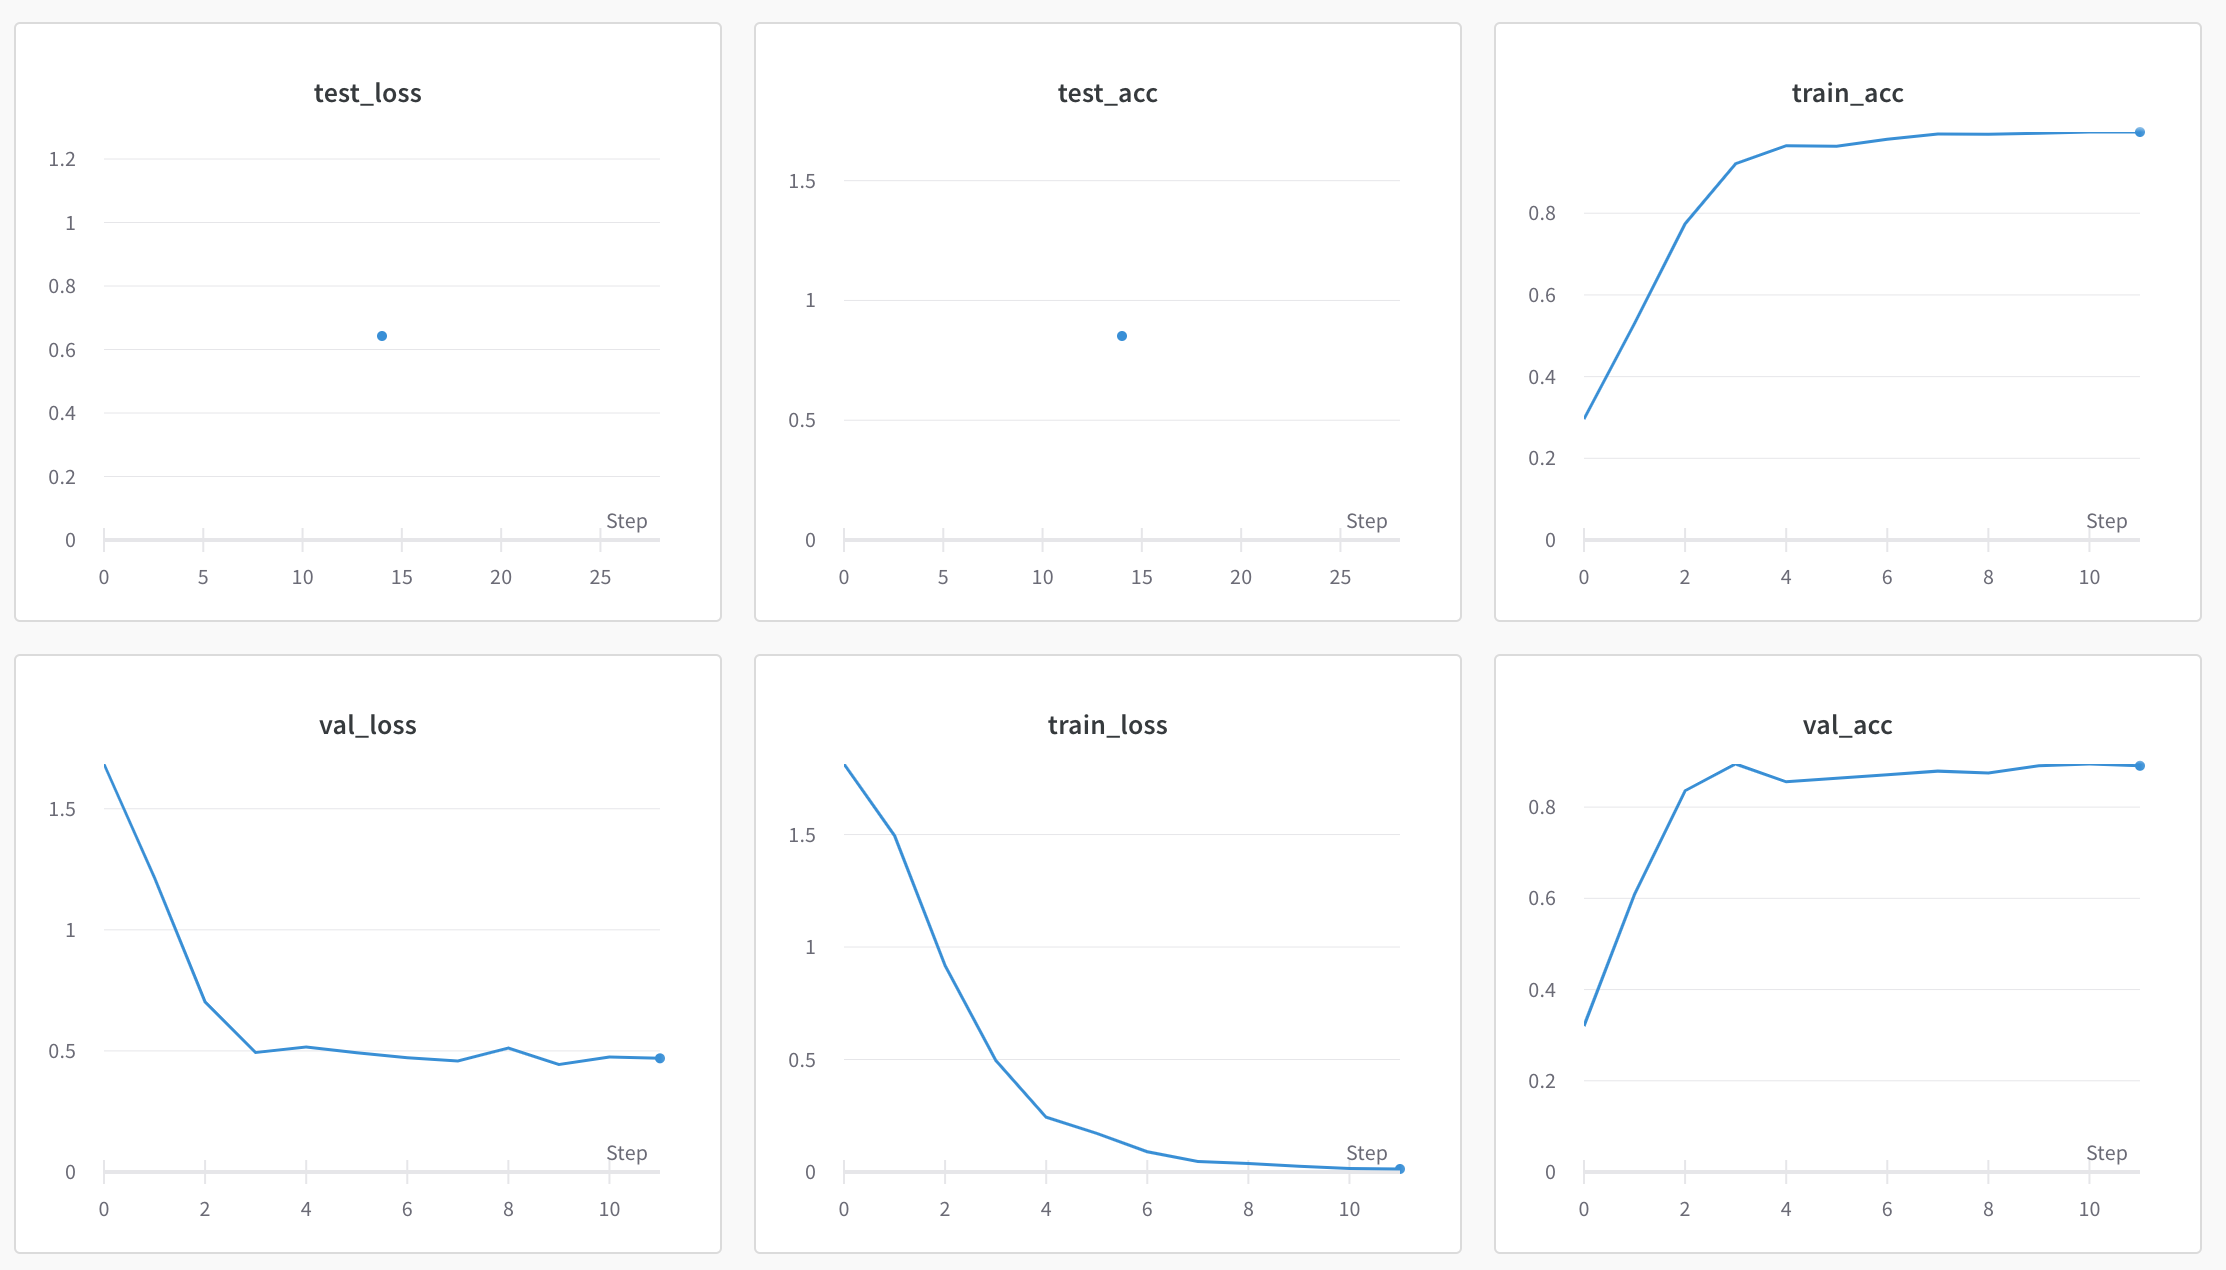

In [14]:
Image(filename='WandB_dashboard.png') #, width=100, height=100)